## WIC Target Index
Using data from the American Community Survey and Western Pennsylvania Regional Data Center, I construct an index representing areas in Allegheny County that would benefit the most from targeted enrollment outreach efforts in WIC. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# prettier pictures
%config InlineBackend.figure_format ='retina'

# set working directory
os.chdir('/users/simonw/ds_1300_notebooks/project')

In [2]:
# import ACS data
acs = pd.read_csv('data/ACS_2022_5year.csv')

# import Western PA data
walkability = pd.read_csv('data/AC_walkability.csv')

# import Census Tract data
tracts = pd.read_csv('data/AC_census_tracts.csv')

# import neighborhood data
hoods = pd.read_csv('data/AC_neighborhoods.csv')

######

# change column name for merging
walkability['GEOID']=walkability["Tract"]

# merge ACS and walkability data together by GEOID
wic_index = pd.merge(acs, walkability, how='inner', on='GEOID')

# merge ACS and Census Tract data together by GEOID
wic_index = pd.merge(wic_index, tracts, how='inner', on='GEOID')

# merge neighborhood names by GEOID
wic_index = pd.merge(wic_index, hoods, how='outer', on='GEOID')

######

wic_index['Total_hh_w_children_6'] = wic_index['Num_hh_w_own_children_6'] + wic_index['Num_hh_w_related_children_6_married'] + wic_index['Num_hh_w_related_children_6_father'] + wic_index['Num_hh_w_related_children_6_mother']

wic_index['Total_hh_no_vehicle'] = wic_index['Num_hh_no_vehicle_owner'] + wic_index['Num_hh_no_vehicle_renter'] 

######

# drop unncessary columns
wic_index = wic_index.drop(columns=['SidewalkStepLFt', 'StreetLFt', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME_y',
                                   'NAMELSAD', 'MTFCC', 'ALAND', 'AWATER', '_id', 'Tract', 'Unnamed: 0',
                                   'FUNCSTAT', 'INTPTLAT', 'INTPTLON', 'Num_hh_w_own_children_6',
                                   'Num_hh_w_related_children_6_married', 'Num_hh_w_related_children_6_father',
                                   'Num_hh_w_related_children_6_mother', 'Num_hh_no_vehicle_owner', 'Num_hh_no_vehicle_renter'])

# renaming columns
wic_index = wic_index.rename(columns={'NAME_x':'Name', 'Ratio':'walkability', 'Num_hh_W_children_snap':'Num_hh_w_children_5_SNAP'})

# reverse code walkability 
wic_index['walkability'] = wic_index['walkability'].astype(float)
wic_index['walkability'] = 2.0-wic_index['walkability']

## Creating a WIC Need Index
Data were pulled from the American Community Survey (ACS) five-year estimates, Southwestern PA Regional Data Center, and the Pennsylvania WIC Program. To quantify a tract’s total level of need, for tracts with sufficient data, its values for each measure of community need were converted into z-scores.13 The z-scores were then averaged into a single score for the tract. A tract’s total score represents how far the tract falls from the mean Allegheny County tract in its level of need. Tracts were systematically sorted into five levels of need (very low to extreme) using the Jenks Natural Breaks method.

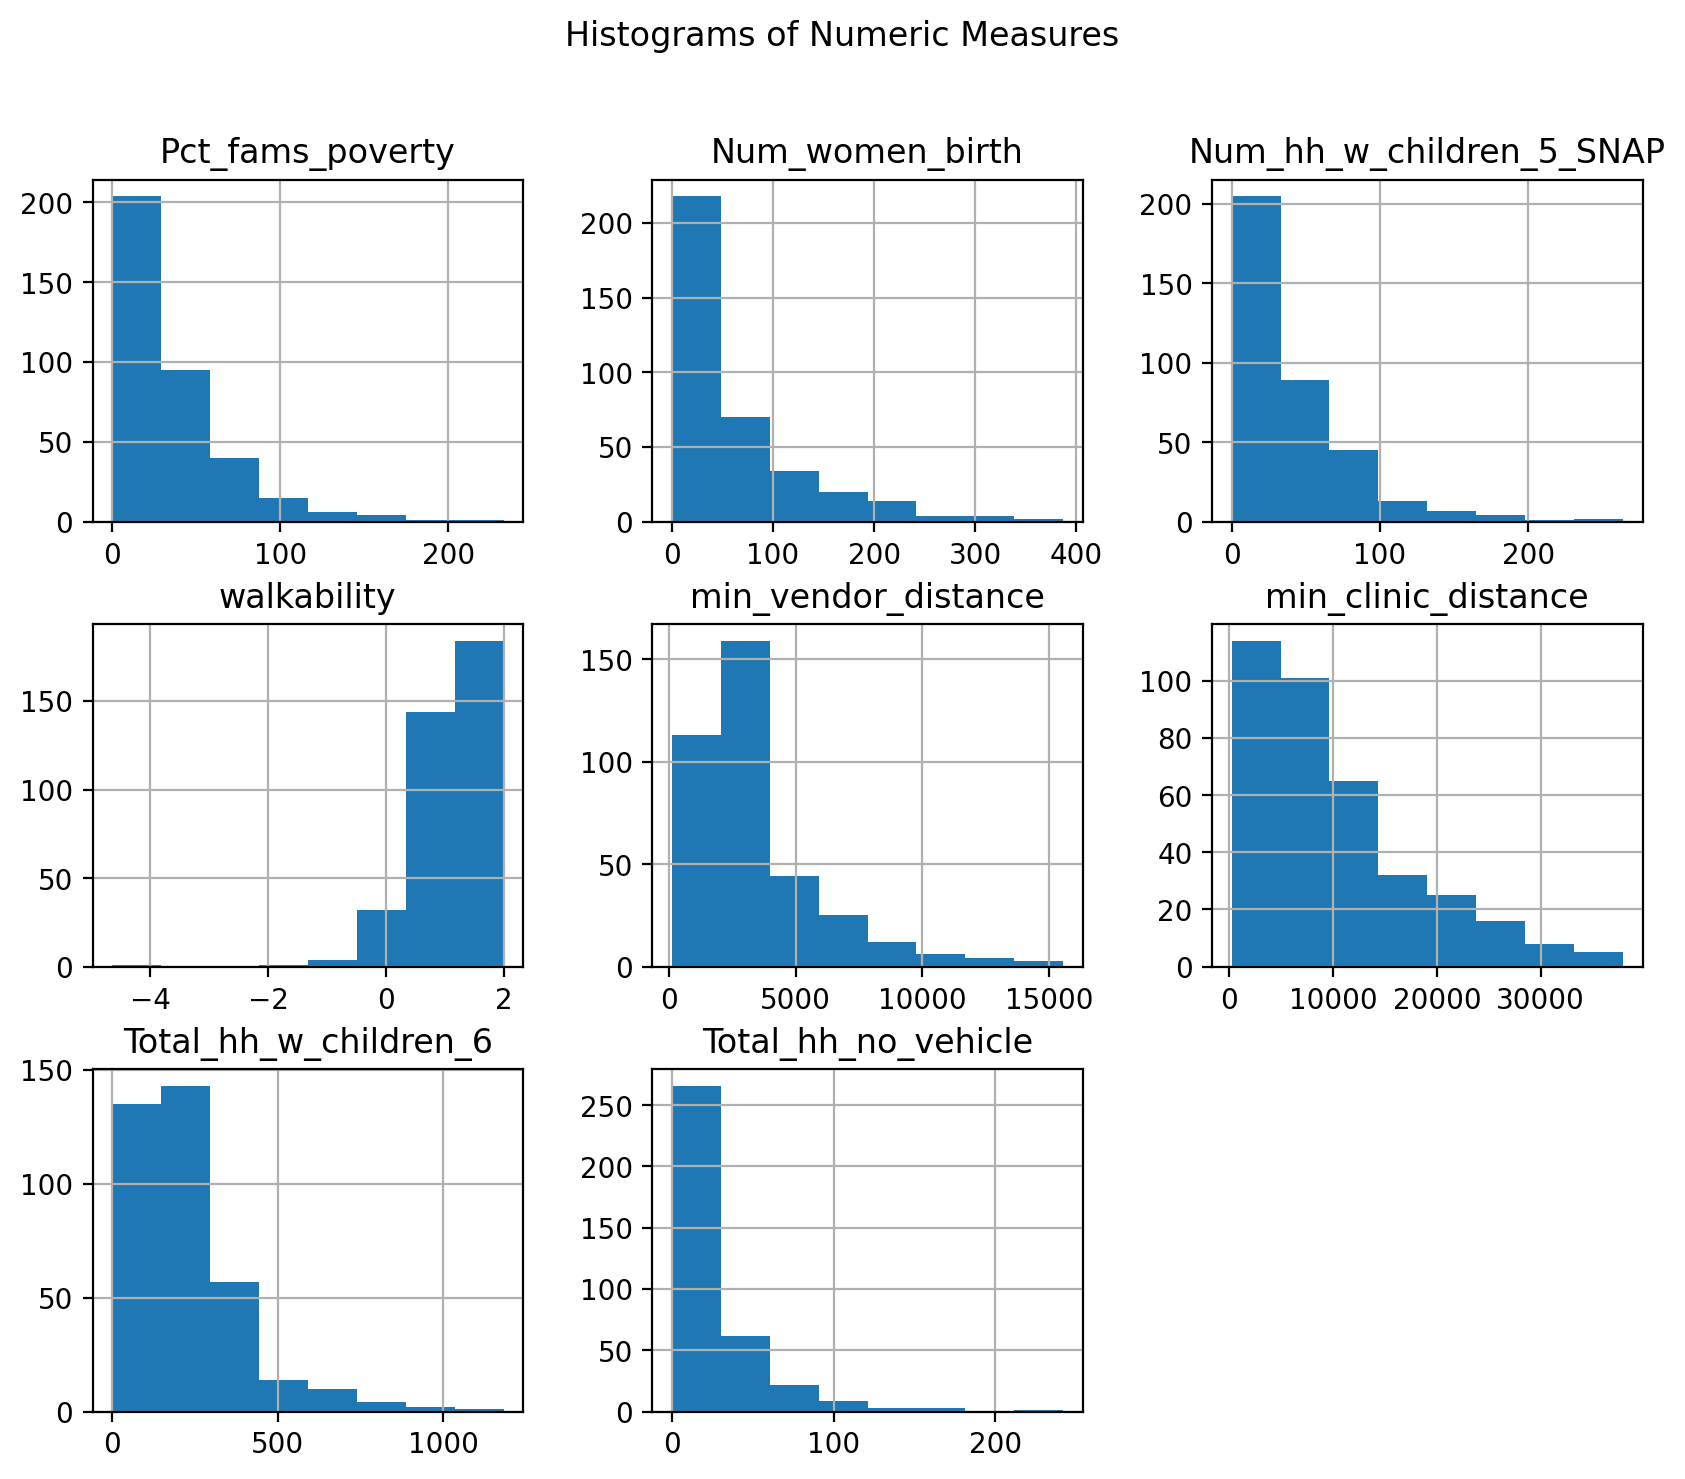

In [3]:
# checking the distributions of my numeric variables
measures = wic_index[['Pct_fams_poverty', 'Num_women_birth', 'Num_hh_w_children_5_SNAP', 'walkability',
                     'min_vendor_distance', 'min_clinic_distance', 'Total_hh_w_children_6', 'Total_hh_no_vehicle']]

measures.hist(bins=8, figsize=(10, 8))
plt.suptitle('Histograms of Numeric Measures')
plt.show()

## Standardization
Although most it not all of the underlying distributions are not normally distributed, we move forward with Z-scoring each variable because the ACS is only a sample. By Central Limit Theorem, it is not unreasonable to assume the entire population follows a normal distribution. 

In [4]:
# ensure all data are stored in numeric format
measures = measures.apply(pd.to_numeric)

In [5]:
# Calculate the z-score for each column
z_scores = measures.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Add z-scores to the original DataFrame with new column names
z_scores.columns = [f'{col}_zscore' for col in z_scores.columns]
wic_index = pd.concat([wic_index, z_scores], axis=1)

# Average z-scores
wic_index['avg_zscore'] = np.mean(wic_index[['Pct_fams_poverty_zscore',
                                  'Num_women_birth_zscore',
                                  'Num_hh_w_children_5_SNAP_zscore',
                                  'walkability_zscore',
                                  'min_vendor_distance_zscore', 
                                  'min_clinic_distance_zscore',
                                  'Total_hh_w_children_6_zscore',
                                  'Total_hh_no_vehicle_zscore']], axis=1)

In [6]:
wic_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   GEOID                            392 non-null    int64  
 1   Name                             366 non-null    object 
 2   Pct_fams_poverty                 366 non-null    float64
 3   Num_women_birth                  366 non-null    float64
 4   Num_hh_w_children_5_SNAP         366 non-null    float64
 5   walkability                      366 non-null    float64
 6   geometry                         366 non-null    object 
 7   centroid                         366 non-null    object 
 8   min_vendor_distance              366 non-null    float64
 9   min_clinic_distance              366 non-null    float64
 10  tract                            378 non-null    float64
 11  municipality                     378 non-null    object 
 12  pgh_neighborhood      

In [7]:
# save data
wic_index.to_csv("/users/simonw/ds_1300_notebooks/project/data/wic_index.csv")

<Axes: >

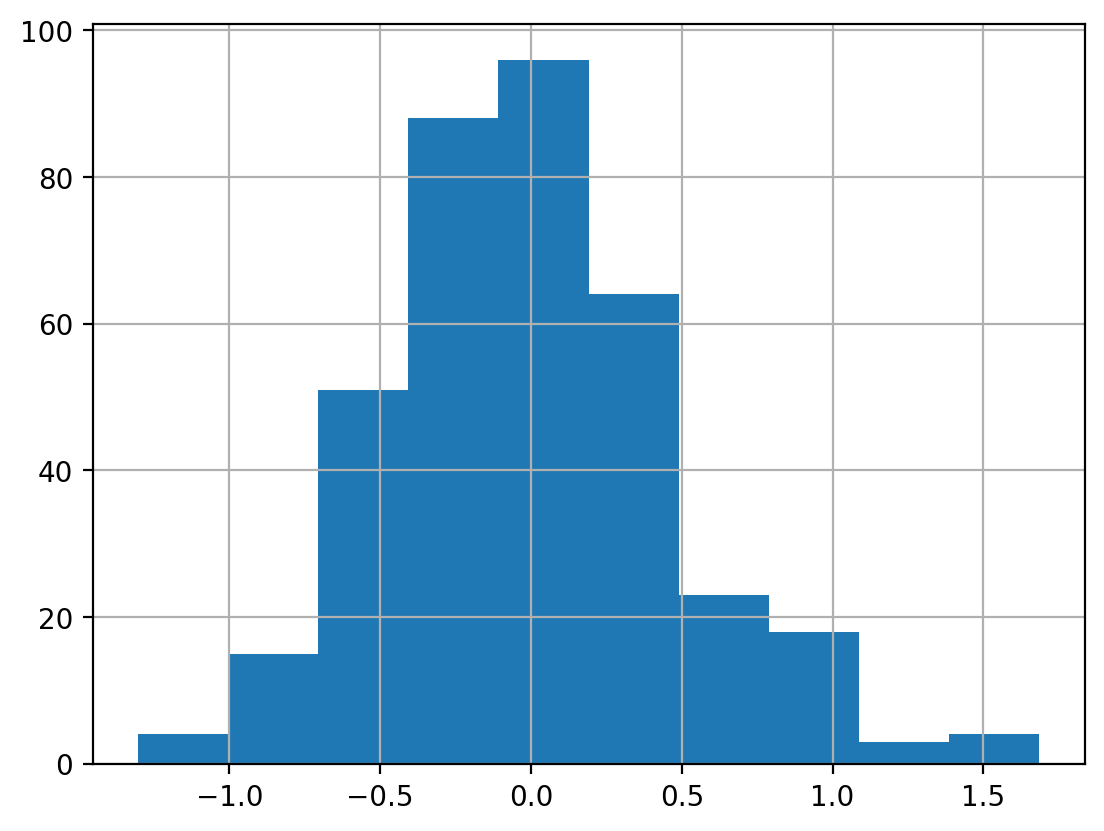

In [8]:
wic_index['avg_zscore'].hist()

<Axes: >

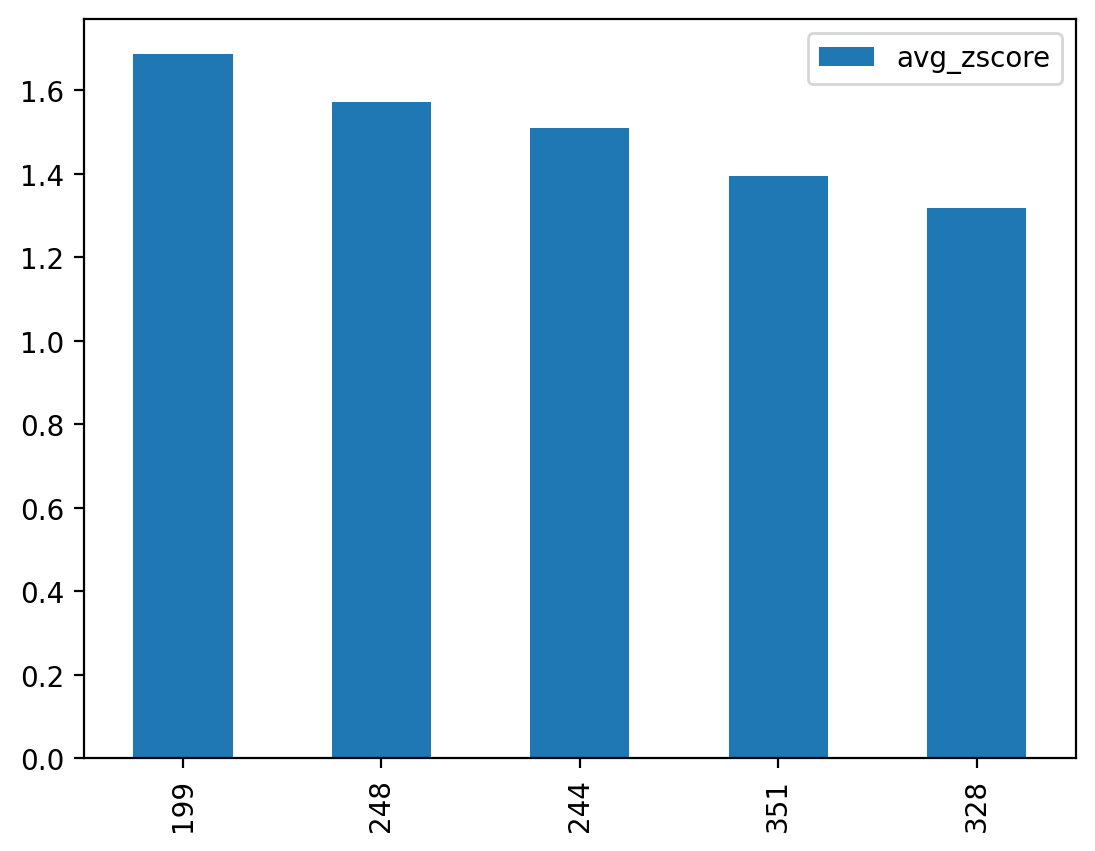

In [9]:
wic_index[['Name', 'avg_zscore']].sort_values('avg_zscore', ascending=False).head(5).plot.bar()

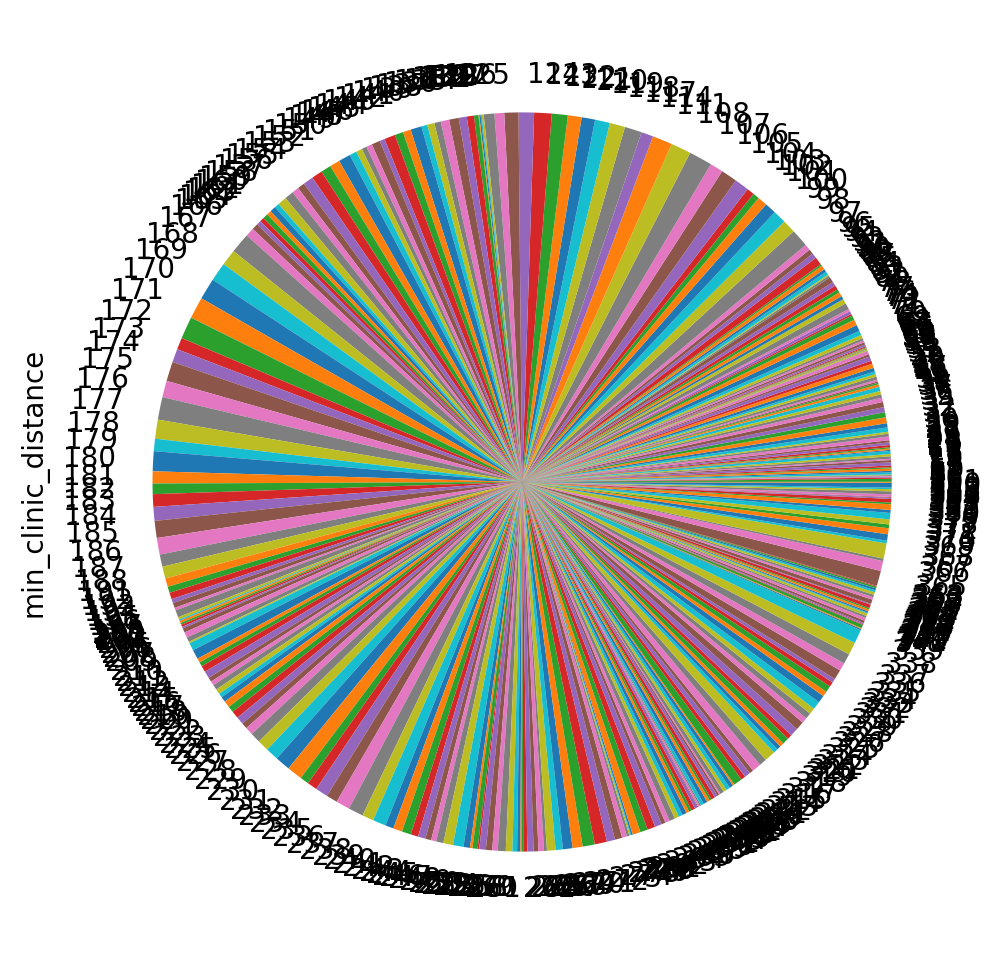

In [12]:
wic_index['min_clinic_distance'].plot.pie(figsize=(6, 6));